In [1]:
import json
import pandas as pd
import random
import numpy as np
import re
import librosa
import torch
import evaluate
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from datasets import Dataset, DatasetDict, load_dataset
from transformers import AutoModelForCTC, Wav2Vec2Processor

# Analisar resultados treinamento

Analisar os resultados das validações realizadas durante o treinamento para escolher o melhor checkpoint

In [2]:
path_json = 'custom/checkpoint-184000/trainer_state.json'
file = open(path_json)
trainer_state = json.load(file)

In [3]:
results = {}
for training_data in trainer_state['log_history']:
    if 'eval_wer' in training_data:
       results[training_data['step']] = [training_data['eval_wer'], training_data['eval_cer'], training_data['eval_loss']]
df = pd.DataFrame(results).transpose()

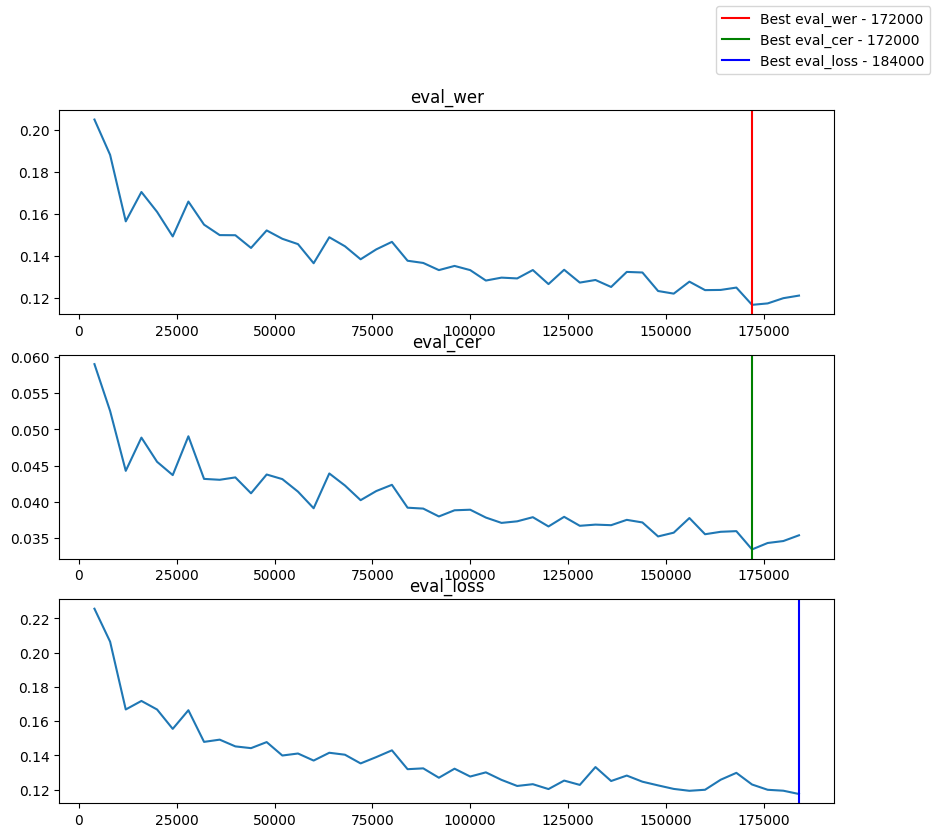

In [4]:
figure, axis = plt.subplots(3)
  
axis[0].plot(df.index, df[0].values)
axis[0].axvline(x = df[[0]].idxmin()[0], color = 'r', label = f'Best eval_wer - {df[[0]].idxmin()[0]}')
axis[0].set_title('eval_wer')
axis[1].plot(df.index, df[1].values)
axis[1].axvline(x = df[[1]].idxmin()[1], color = 'g', label = f'Best eval_cer - {df[[1]].idxmin()[1]}')
axis[1].set_title('eval_cer')
axis[2].plot(df.index, df[2].values)
axis[2].axvline(x = df[[2]].idxmin()[2], color = 'b', label = f'Best eval_loss - {df[[2]].idxmin()[2]}')
axis[2].set_title('eval_loss')
figure.legend()
figure.set_figheight(9)
figure.set_figwidth(10)

In [5]:
print('         eval_wer - eval_cer - eval_loss')
print(f'172000: {df.loc[172000].values}')
print(f'184000: {df.loc[184000].values}')

         eval_wer - eval_cer - eval_loss
172000: [0.11680074 0.03345439 0.12292832]
184000: [0.1211919  0.03540317 0.11736854]


# Testar Checkpoint

Carregar modelo

In [6]:
def show_elements(dataset, num_examples=10):
    if num_examples > len(dataset):
        num_examples = len(dataset)
        
    df = pd.DataFrame(dataset[range(num_examples)])
    display(HTML(df.to_html()))

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
#path = 'facebook/wav2vec2-large-xlsr-53-portuguese'
#path = 'ProgramadorArtificial/wav2vec2-large-xlsr-53-portuguese'
path = 'custom/checkpoint-172000'
processor = Wav2Vec2Processor.from_pretrained(path)
model = AutoModelForCTC.from_pretrained(path)
model.to(device)

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (2): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (3): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elemen

## Rodar modelo em um dataset

### Carregar dataset

In [9]:
dataset_dict = DatasetDict()
dataset_dict['train'] = Dataset.from_pandas(pd.read_csv('tsv/train.tsv', sep='\t'))
dataset_dict['test'] = Dataset.from_pandas(pd.read_csv('tsv/test.tsv', sep='\t'))
dataset_dict['validation'] = Dataset.from_pandas(pd.read_csv('tsv/validation.tsv', sep='\t'))

In [10]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['path', 'sentence'],
        num_rows: 151936
    })
    test: Dataset({
        features: ['path', 'sentence'],
        num_rows: 18993
    })
    validation: Dataset({
        features: ['path', 'sentence'],
        num_rows: 18992
    })
})

### Remover caracteres não tokenizados

In [11]:
#chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'
chars_to_ignore_regex = '[\,\?\.\!\;\:\"\“\%\‘\”\’\(\)\[\]\«\»\·]'
chars_to_replace = {
    "&": 'e',
    '/': ' ',
    '´': "'",
    'ü': 'u',
    '– ': ''
}
# Remove sentence when there is the follow characters
chars_to_remove = ['ı', 'š', 'ž', '\xa0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

def remove_special_characters(batch):
    batch["sentence"] = re.sub(chars_to_ignore_regex, '', batch["sentence"]).lower()
    for key, value in chars_to_replace.items():
        batch["sentence"] = batch["sentence"].replace(key, value)
    
    # Remove multiple spaces
    batch['sentence'] = " ".join(batch['sentence'].split())
    
    for char_to_remove in chars_to_remove:
        if batch['sentence'].find(char_to_remove) != -1:
            batch['sentence'] = None
            break
    
    # Can change the "find" to parse sentences with the character
    if batch['sentence'] and batch['sentence'].find('·') != -1:
        print(batch)
    return batch

### Carregar funções necessárias

Para fazer a leitura e pré-processamento dos áudios

In [12]:
def prepare_data(batch):
    audio, _ = librosa.load(batch['path'], sr=16000)
    
    batch["input_values"] = processor(audio, sampling_rate=16000, padding=True, do_normalize=True, return_attention_mask=True).input_values
    batch['labels'] = processor.tokenizer(batch['sentence']).input_ids
        
    return batch

Carregar calculos de erro

In [13]:
wer_metric = evaluate.load('wer') # Word error rate
cer_metric = evaluate.load('cer') # Character error rate

Para converter áudio para tensor, rodar modelo e retornar os resultados

In [14]:
def map_to_result(batch):
    result = {}
    data_prepared = prepare_data(batch.copy())
    #print(np.array(data_prepared['input_values']))
    with torch.no_grad():
        input_values = torch.tensor(np.array(data_prepared["input_values"]), device="cuda")
        
        logits = model(input_values).logits

    pred_ids = torch.argmax(logits, dim=-1)
    result["pred_str"] = processor.batch_decode(pred_ids)[0]
    result["text"] = processor.decode(data_prepared["labels"], group_tokens=False)
    return result

Para ajudar a identificar as palavras diferentes entre a predição do modelo e o valor real

In [15]:
def difference(result):
    string1 = result['pred_str'].split()
    string2 = result['text'].split()

    A = set(string1)
    B = set(string2)

    str_diff = A.symmetric_difference(B)
    if str_diff == set():
        diff_pred_str = None
        diff_text = None
    else:
        diff_pred_str = []
        diff_text = []
        for text in str_diff:
            if text in string1:
                diff_pred_str.append(text)
            else:
                diff_text.append(text)
    return({'diff_pred_str': diff_pred_str, 'diff_text': diff_text})

### Rodar o modelo e ver resultado

#### Dataset de test

In [16]:
results = dataset_dict["test"].map(map_to_result, remove_columns=dataset_dict["test"].column_names)

Map:   0%|          | 0/18993 [00:00<?, ? examples/s]

In [17]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results["pred_str"], references=results["text"])))

Test WER: 0.117
Test CER: 0.033


In [18]:
results_diff = results.map(difference)
results_diff = Dataset.from_pandas(Dataset.to_pandas(results_diff).dropna()).remove_columns(["__index_level_0__"])
show_elements(results_diff)

Map:   0%|          | 0/18993 [00:00<?, ? examples/s]

,pred_str,text,diff_pred_str,diff_text
0,os empréstimos do banco mundial exigem contrapartidas do governo beneficiados,os empréstimos do banco mundial exigem contrapartidas dos governos beneficiados,[governo],"[governos, dos]"
1,mwendel queiroz rodrigues,wendell queiroz rodrgues,"[rodrigues, mwendel]","[rodrgues, wendell]"
2,virmontes,virmond,[virmontes],[virmond]
3,albaniza de sontos brico,albaniza dos santos brito,"[brico, sontos, de]","[santos, brito, dos]"
4,escreve uma carta para eles a semana passada,escrevi uma carta para eles na semana passada,"[escreve, a]","[escrevi, na]"
5,uma garota vestindo uma jaqueta e caxicol está jogando na praia,uma garota vestindo uma jaqueta e cachecol está jogando na praia,[caxicol],[cachecol]
6,a senhora tem em seu poder um papel que o meu amigo lhe deu aguardar recomendando me que no caso de acontecer-lhe alguma cousa lhe avisasse para abri-lo parece que tinha um pressentimento,a senhora tem em seu poder um papel que o meu amigo lhe deu a guardar recomendando me que no caso de acontecer lhe alguma cousa lhe avisasse para abri-lo parece que tinha um pressentimento,"[acontecer-lhe, aguardar]","[acontecer, guardar]"
7,o enforcado seguia ao seu lado com passos tão ligeiros que mesmo quando d rui galopava ele se conservava rente aos tribo como levado por um vento mudo,o enforcado seguia ao seu lado com passos tam ligeiros que mesmo quando d rui galopava êle se conservava rente ao estribo como levado por um vento mudo,"[tão, tribo, aos, ele]","[êle, tam, estribo]"
8,a viação de mercado scitado,a aviação é um mercado disputado,"[scitado, viação, de]","[disputado, um, aviação, é]"
9,deixou-se o poeta com assua inspiração arrebatadora de bom tempo recomeçou a investida aos pratos a abóbada de folhagem que nos cobria em vez de atenuar a violência das águas concorria para fazer mais grossos os pingos,de desordem deixou-se o poeta com a sua inspiração arrebatadora de bom tempo recomeçou a investida aos pratos a abóbada de folhagem que nos cobria em vez de atenuar a violência das águas concorria para fazer mais grossos os pingos,[assua],"[desordem, sua]"


#### Dataset de validation

In [19]:
results2 = dataset_dict["validation"].map(map_to_result, remove_columns=dataset_dict["train"].column_names)

Map:   0%|          | 0/18992 [00:00<?, ? examples/s]

In [20]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results2["pred_str"], references=results2["text"])))
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results2["pred_str"], references=results2["text"])))

Test WER: 0.095
Test CER: 0.026


In [21]:
results_diff2 = results2.map(difference)
results_diff2 = Dataset.from_pandas(Dataset.to_pandas(results_diff2).dropna()).remove_columns(["__index_level_0__"])
show_elements(results_diff2)

Map:   0%|          | 0/18992 [00:00<?, ? examples/s]

,pred_str,text,diff_pred_str,diff_text
0,pontex gestal,pontes gestal,[pontex],[pontes]
1,os modos de seu pensamento as cendências de seu espírito e até as menores particularidades de sua vida é nessa fonte que deve beber o poeta brasileiro é dela que há de sair o verdadeiro poema nacional tal como eu o imagino,os modos de seu pensamento as tendências de seu espírito e até as menores particularidades de sua vida é nessa fonte que deve beber o poeta brasileiro é dela que há de sair o verdadeiro poema nacional tal como eu o imagino,[cendências],[tendências]
2,revolucionario engajado na luta armada contra a vevonosa detadura militar essuas atrecidades,revolucionário engajado na luta armada contra a vergonhosa ditadura militar e suas atrocidades,"[revolucionario, essuas, vevonosa, detadura, atrecidades]","[revolucionário, ditadura, e, vergonhosa, atrocidades, suas]"
3,perdeu a esperança de enriquecer e deu-se todo todo inteiro a felicidade de possuir a mulata e ser possuído só por ela só ela e mais ninguém,perdeu a esperança de enriquecer e deu-se todo todo inteiro à felicidade de possuir a mulata e ser possuído só por ela só ela e mais ninguém,[],[à]
4,para o carnaval vio mais pom,para o carnaval vi mais pão,"[vio, pom]","[pão, vi]"
5,estiveram aqui levaram o homem morto as mulas e ainda pegaram alcumas das nossas jóias e moedas,estiveram aqui levaram o homem morto as mulas e ainda pegaram algumas das nossas jóias e moedas,[alcumas],[algumas]
6,quantos anos tem ela o mosce,quantos anos tem elon musk,"[o, ela, mosce]","[musk, elon]"
7,parábola do bom samaretano,parábola do bom samaritano,[samaretano],[samaritano]
8,mas rezava todas as noites com fervor ou pelo menos com sono tinha medo as trovoadas nessas ocasiões tapava os ouvidos e resmuniava todas as orações do catecismo,mas rezava todas as noites com fervor ou pelo menos com somno tinha medo ás trovoadas nessas occasiões tapava os ouvidos e resmoneava todas as orações do catecismo,"[resmuniava, sono, ocasiões]","[occasiões, somno, resmoneava, ás]"
9,esta diferença acabou se refletindo no o índice de julho,esta diferença acabou se refletindo no índice de julho,[o],[]


### Avaliar somente o dataset customizado

#### Dataset de test (custom)

In [22]:
pd_dataset_dict_test = Dataset.to_pandas(dataset_dict['test']) 
pd_dataset_dict_test = pd_dataset_dict_test.loc[pd_dataset_dict_test['path'].str.contains("custom_dataset")]
dataset_dict_test = Dataset.from_pandas(pd_dataset_dict_test).remove_columns(["__index_level_0__"])
results_custom_dataset = dataset_dict_test.map(map_to_result, remove_columns=dataset_dict_test.column_names)

Map:   0%|          | 0/362 [00:00<?, ? examples/s]

In [23]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results_custom_dataset["pred_str"], references=results_custom_dataset["text"])))
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results_custom_dataset["pred_str"], references=results_custom_dataset["text"])))

Test WER: 0.136
Test CER: 0.036


In [24]:
results_diff_custom_dataset = results_custom_dataset.map(difference)
results_diff_custom_dataset = Dataset.from_pandas(Dataset.to_pandas(results_diff_custom_dataset).dropna()).remove_columns(["__index_level_0__"])
show_elements(results_diff_custom_dataset)

Map:   0%|          | 0/362 [00:00<?, ? examples/s]

,pred_str,text,diff_pred_str,diff_text
0,caminhavam rapidamente para escapar da fura do terrível gigante,caminhavam rapidamente para escapar da fúria do terrível gigante,[fura],[fúria]
1,ninguém no país podia comer dos novos eames antes da festa,ninguém no país podia comer dos novos inhames antes da festa,[eames],[inhames]
2,apenas um deles era perneda como fora o última serfundido falto o combo para completar a outra perna,apenas um deles era perneta como fora o último a ser fundido faltou chumbo para completar a outra perna,"[perneda, falto, última, combo, serfundido]","[perneta, fundido, chumbo, ser, faltou, último]"
3,uma planta tão comprida não pode ser minha filha,uma planta tão comprida não pode ser a minha filha,[],[a]
4,era velho fraco e os filhos não ajudavaem quase nada,era velho fraco e os filhos não o ajudavam em quase nada,[ajudavaem],"[o, em, ajudavam]"
5,as pessoas assustadas comentavam a,as pessoas assustadas comentavam ah,[a],[ah]
6,toda vez que penso a canção acabou simplesmente aconteceu alco maior e muito melhor,toda vez que penso a canção acabou simplesmente acontece algo maior e muito melhor,"[aconteceu, alco]","[algo, acontece]"
7,tecerom a um subterrâneo e o homem indicou umalage no chão,desceram a um subterrâneo e o homem indicou uma laje no chão,"[tecerom, umalage]","[laje, uma, desceram]"
8,dela começaram a sair a conos sons,dela começaram a sair alguns sons,[conos],[alguns]
9,som de moeda caindo uma por cima das outras,som de moedas caindo umas por cima das outras,"[moeda, uma]","[moedas, umas]"


#### Dataset de validation (custom)

In [25]:
pd_dataset_dict_valid = Dataset.to_pandas(dataset_dict['validation']) 
pd_dataset_dict_valid = pd_dataset_dict_valid.loc[pd_dataset_dict_valid['path'].str.contains("custom_dataset")]
dataset_dict_valid = Dataset.from_pandas(pd_dataset_dict_valid).remove_columns(["__index_level_0__"])
results_custom_dataset2 = dataset_dict_valid.map(map_to_result, remove_columns=dataset_dict_valid.column_names)

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

In [26]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results_custom_dataset2["pred_str"], references=results_custom_dataset2["text"])))
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results_custom_dataset2["pred_str"], references=results_custom_dataset2["text"])))

Test WER: 0.092
Test CER: 0.021


In [27]:
results_diff_custom_dataset2 = results_custom_dataset2.map(difference)
results_diff_custom_dataset2 = Dataset.from_pandas(Dataset.to_pandas(results_diff_custom_dataset2).dropna()).remove_columns(["__index_level_0__"])
show_elements(results_diff_custom_dataset2)

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

,pred_str,text,diff_pred_str,diff_text
0,estiveram aqui levaram o homem morto as mulas e ainda pegaram alcumas das nossas jóias e moedas,estiveram aqui levaram o homem morto as mulas e ainda pegaram algumas das nossas jóias e moedas,[alcumas],[algumas]
1,branca de neve cresceu e a cada ano mais linda,branca de neve cresceu a cada ano mais linda,[e],[]
2,ele definitivamente queria estar lar ir brincar e conversar com os outros fazer parte,ele definitivamente queria estar lá rir brincar e conversar com os outros fazer parte,"[ir, lar]","[lá, rir]"
3,voz feminina grito forte que vai morrendo aos poucos até subir,voz feminina grito forte que vai morrendo aos poucos até sumir,[subir],[sumir]
4,um certo feiticeiro lhe dera um espelho mágico a qual todos os dias ela perguntava com vaidade espelho espelho meu diga-me seá no mundo mulher mais bela do que eu,um certo feiticeiro lhe dera um espelho mágico ao qual todos os dias ela perguntava com vaidade espelho espelho meu diga-me se há no mundo mulher mais bela do que eu,"[a, seá]","[se, há, ao]"
5,um belo dia chegaram a capital do reino dois pilantras muito habilidosas em viverm as custas do próximo,um belo dia chegaram à capital do reino dois pilantras muito habilidosos em viver às custas do próximo,"[a, as, habilidosas, viverm]","[às, viver, habilidosos, à]"
6,um dia por acasa o príncipe chegou ao deserto no qual rapunzel vivia na maior tristeza com seus filhos dmes um menino e uma menina que haviam nascido ali,um dia por acaso o príncipe chegou ao deserto no qual rapunzel vivia na maior tristeza com seus filhos gêmeos um menino e uma menina que haviam nascido ali,"[acasa, dmes]","[acaso, gêmeos]"
7,aqui está o que sua filha mandou trazeir comida e bebida,aqui está o que sua filha mandou trazer comida e bebida,[trazeir],[trazer]
8,o soldadinho também se disse solveu completamente,o soldadinho também se dissolveu completamente,"[solveu, disse]",[dissolveu]
9,chega de foga,chega de folga,[foga],[folga]


#### Dataset de train (custom)

In [28]:
pd_dataset_dict_train = Dataset.to_pandas(dataset_dict['train']) 
pd_dataset_dict_train = pd_dataset_dict_train.loc[pd_dataset_dict_train['path'].str.contains("custom_dataset")]
dataset_dict_train = Dataset.from_pandas(pd_dataset_dict_train).remove_columns(["__index_level_0__"])
results_custom_dataset3 = dataset_dict_train.map(map_to_result, remove_columns=dataset_dict_train.column_names)

Map:   0%|          | 0/3077 [00:00<?, ? examples/s]

In [29]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results_custom_dataset3["pred_str"], references=results_custom_dataset3["text"])))
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results_custom_dataset3["pred_str"], references=results_custom_dataset3["text"])))

Test WER: 0.096
Test CER: 0.024


In [30]:
results_custom_dataset3 = results_custom_dataset3.map(difference)
results_custom_dataset3 = Dataset.from_pandas(Dataset.to_pandas(results_custom_dataset3).dropna()).remove_columns(["__index_level_0__"])
show_elements(results_custom_dataset3)

Map:   0%|          | 0/3077 [00:00<?, ? examples/s]

,pred_str,text,diff_pred_str,diff_text
0,o que está fazendo que instrumenta esse sem levantar os olhos do seu trabalho a velhinha respondeu com o arbunachão não está vendo e estou fiando,o que está fazendo que instrumento é esse sem levantar os olhos do seu trabalho a velhinha respondeu com ar bonachão não está vendo estou fiando,"[e, instrumenta, arbunachão]","[ar, instrumento, é, bonachão]"
1,acho que está um pouco magra mas não é nada sédio não é verdade,acho que está um pouco magra mas não é nada sério não é verdade,[sédio],[sério]
2,então joão começou a infoar senhor marreco bom nada dor somos filhos do lenhador nos leve para outra margem temos que seguir de viagem,então joão começou a entoar senhor marreco bom nadador somos filhos do lenhador nos leve para a outra margem temos que seguir viagem,"[nada, de, dor, infoar]","[entoar, nadador]"
3,bom vou tratar do meu trabalho pois o dia passa depressa,bem vou tratar do meu trabalho pois o dia passa depressa,[bom],[bem]
4,abra-te sésimo,abre-te sésamo,"[abra-te, sésimo]","[sésamo, abre-te]"
5,e agora em diante meu jardim será um parque de diversões para as crianças,de agora em diante meu jardim será um parque de diversões para as crianças,[e],[]
6,vovó como são grandes o seus dentes,vovó como são grandes os seus dentes,[o],[os]
7,o garoto pegou todo o ouro e toda a prata que havia na moncanha voltou para casa e como você pode imaginar que toas dívidas da família,o garoto pegou todo o ouro e toda a prata que havia na montanha voltou para casa e como você pode imaginar quitou as dívidas da família,"[toas, moncanha]","[montanha, as, quitou]"
8,vá e mistura e se ada multidão deu uma olhada nas pessoas ouça o que elas têm a dizer e abra o seu coração,vá e misture-se à multidão dê uma olhada nas pessoas ouça o que elas têm a dizer e abra o seu coração,"[deu, se, ada, mistura]","[dê, misture-se, à]"
9,de quem será que eles roubaram tanta riqueza,de quem será que eles roubam tanta riqueza,[roubaram],[roubam]


### Rodar somente um áudio

In [4]:
file_loaded = librosa.load('datasets/FalaBrasil/alcaim16k-DVD4de4-master/HenriqueMafra_M046/M046-0467.wav', sr=16000)[0]

input_values = processor(file_loaded, sampling_rate=16000, padding=True).input_values
input_values = torch.tensor(np.array(input_values), device=device)
logits = model(input_values).logits
pred_ids = torch.argmax(logits, dim=-1)
#a = [1 if pred_id == 0 else pred_id for pred_id in pred_ids[0].tolist()]
#print(a)
#print(f'\nAntes agrupamento: {"".join(processor.tokenizer.convert_ids_to_tokens(a))}')
print(pred_ids[0].tolist())
print(f'\nAntes agrupamento: {"".join(processor.tokenizer.convert_ids_to_tokens(pred_ids[0].tolist()))}')
print(f'\nResultado: {processor.batch_decode(pred_ids)[0]}')

[43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 34, 43, 43, 43, 0, 0, 0, 43, 43, 7, 43, 43, 24, 43, 43, 11, 43, 43, 43, 43, 6, 6, 43, 43, 43, 7, 43, 43, 16, 16, 43, 43, 43, 43, 22, 22, 43, 43, 7, 43, 43, 0, 0, 0, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 19, 23, 23, 7, 7, 7, 43, 43, 0, 0, 0, 43, 43, 43, 7, 43, 43, 43, 21, 43, 43, 43, 43, 43, 43, 43, 22, 22, 22, 43, 7, 43, 0, 0, 43, 43, 43, 43, 43, 43, 43, 43, 7, 7, 43, 43, 43, 43, 43, 43, 24, 43, 43, 43, 7, 43, 43, 16, 43, 43, 43, 43, 22, 22, 43, 17, 43, 43, 0, 0, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 34, 34, 43, 43, 43, 0, 0, 0, 0, 0, 43, 43, 7, 43, 43, 26, 43, 43, 43, 43, 43, 43, 43, 22, 43, 20, 20, 7, 7, 43, 43, 15, 43, 43, 3, 3, 43, 43, 43, 43, 43, 15, 43, 7, 43, 43, 43, 43, 16, 43, 43, 22, 43, 7, 0, 0, 43, 43, 43, 5, 5, 17, 17, 15, 43, 43, 43, 43, 43, 43, 18, 18, 43, 14, 43, 43, 43, 7, 43, 43, 43, 43, 43, 43, 43, 43, 43, 26, 43, 43, 43, 43, 17, 43, 0, 0, 43, 43, 43, 

## Testar libs
Verificar se as bibliotecas possuem o mesmo output ao abrir um arquivo

In [32]:
from datasets import Audio, Dataset
import librosa

In [33]:
path = 'datasets/FalaBrasil/alcaim16k-DVD4de4-master/HenriqueMafra_M046/M046-0467.wav'
using_dataset_audio = Dataset.from_dict({"audio": [path]}).cast_column("audio", Audio(sampling_rate=processor.feature_extractor.sampling_rate))['audio'][0]['array']
using_librosa = librosa.load(path, sr=processor.feature_extractor.sampling_rate)[0]

In [34]:
using_dataset_audio

array([-3.35693359e-04, -4.27246094e-04, -1.52587891e-04, ...,
        2.44140625e-04,  6.10351562e-05, -1.22070312e-04])

In [35]:
using_librosa

array([-3.3569336e-04, -4.2724609e-04, -1.5258789e-04, ...,
        2.4414062e-04,  6.1035156e-05, -1.2207031e-04], dtype=float32)

Aparentemente sim, as duas bibliotecas possuem o mesmo output. Pode ser utilizada qualquer uma das duas para carregar os arquivos

In [36]:
all(using_dataset_audio == using_librosa)

True